In [97]:
import random
import math
import operator
from deap import base
from deap import creator
from deap import tools
from deap import algorithms

In [98]:
# Dimension number (number of the attributes)
DIM_SIZE = 30
# Domain of the problem
MIN_VALUES = -500.0
MAX_VALUES = 500.0


In [99]:
#Create type for minimization of the function
creator.create("FitnessMin",base.Fitness,weights=(-1.0,))

#Create type for store individual (in this example we use list) 
creator.create("Particle", list, fitness=creator.FitnessMin, v = list, smin = None, smax = None, p = None)


In [100]:
# Definition of the particle (additional content)
def initParticle(size, pmin, pmax, smin, smax):
    particle = creator.Particle(random.uniform(pmin, pmax) for _
    in range(size))
    particle.v = [random.uniform(pmin, pmax) for _ in range(size)]
    particle.smin = smin
    particle.smax = smax
    return particle

In [101]:
#Create toolbox for register needed functions
toolbox = base.Toolbox()

#Register function used for init the individuals
toolbox.register("individual", initParticle, size=DIM_SIZE, 
pmin=MIN_VALUES, pmax=MAX_VALUES, 
                 smin=MIN_VALUES/2.0,smax=MAX_VALUES/2.0)

#Register function for create population of individuals
toolbox.register("population",tools.initRepeat, list, 
toolbox.individual)


In [102]:
# Create the function for update the speed of the particle 
# (particle.v), actual position (particle) 
# using local best position (particle.p),
# and global best position (g)
def updateParticle(particle, g, c1, c2):
    #random numbers (arrays)
    u1 = (random.uniform(0, c1) for _ in range(len(particle)))
    u2 = (random.uniform(0, c2) for _ in range(len(particle)))
    
    # Map - Equations for speed parts
    v_u1 = map(operator.mul, u1, map(operator.sub, particle.p, particle))
    v_u2 = map(operator.mul, u2, map(operator.sub, g, particle))
   
    # Map - Equations for speed update
    particle.v = list(map(operator.add, particle.v, map(operator.add, v_u1, v_u2)))
    
    #Performing the v update, and check constrains of speed (v)
    for i, v in enumerate(particle.v):
        if abs(v) < particle.smin:
            particle.v[i] = math.copysign(particle.smin, v)
        elif abs(v) > particle.smax:
            particle.v[i] = math.copysign(particle.smax, v)
            
    #Performing the particle update (current position)
    particle[:] = list(map(operator.add,particle, particle.v))
    

In [103]:
# Create the function for update the speed of the particle (v), actual position (particle) using local best position
# particle.p and global best position (g)
# LDPSO verison with the w parameter w
def updateParticle_LDPSO(particle, g, w, c1, c2):
    #random numbers (arrays)
    u1 = (random.uniform(0, c1) for _ in range(len(particle)))
    u2 = (random.uniform(0, c2) for _ in range(len(particle)))
    
    # Map - Equations for speed parts
   
    v_u1 = map(operator.mul, u1, map(operator.sub, particle.p, particle))
    v_u2 = map(operator.mul, u2, map(operator.sub, g, particle))
    
    w_v = [w * v for v in particle.v]
    
    # Map - Equations for speed update
    particle.v = list(map(operator.add,w_v, map(operator.add, v_u1, v_u2)))
    
    #Performing the v update, and check constrains of speed (v)
    for i, v in enumerate(particle.v):
        if abs(v) < particle.smin:
            particle.v[i] = math.copysign(particle.smin, v)
        elif abs(v) > particle.smax:
            particle.v[i] = math.copysign(particle.smax, v)
            
    #Performing the particle update (current position)
    particle[:] = list(map(operator.add,particle, particle.v))


In [104]:
# The power function (domain <-100,100>)
def F1(tab):
    return sum([x*x for x in tab]),


In [105]:
# <-10.10>
def F2(tab):
    suma = sum([abs(x) for x in tab])
    mul = 1
    for x in tab:
        mul*= abs(x)
    return suma + mul,

In [106]:
# Definition of the Generalized Schwefel Problem 2.26 (F8) (domain <-500, 500>)
def F8(tab):
    return sum([ math.sin(math.sqrt(abs(x))) for x in tab]),


In [110]:
# For the base version
toolbox.register("update", updateParticle,c1=2.5, c2=2.5)
# LDPSO version
#toolbox.register("update", updateParticle_LDPSO, w=0.8, c1=2.0, c2=2.0)
toolbox.register("evaluate",F2)

In [111]:
import numpy
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg",numpy.mean)
stats.register("std",numpy.std)
stats.register("min",numpy.min)
stats.register("max",numpy.max)


In [112]:
# A base PSO alg (Eberhart and Russel 1995)
def PSO_ALG(NGEN,POPSIZE,stats):
    # Loogs
    logbook = tools.Logbook()
    g_history = []
    # Create a population of the solutions
    pop = toolbox.population(n=POPSIZE)
    # Global best soultion
    g = None
    
    for gen in range(NGEN):
        for part in pop:
            part.fitness.values = toolbox.evaluate(part)
            # Create or update local best
            if not part.p or part.p.fitness < part.fitness:
                part.p = creator.Particle(part)
                part.p.fitness.values = part.fitness.values
                
            # Create or update global best
            if not g or g.fitness < part.fitness:
                g = creator.Particle(part)
                g.fitness.values = part.fitness.values
            # Move the population
    
        for part in pop:
            toolbox.update(part,g)
        # Recodr statistics about population 
        record = stats.compile(pop)
        logbook.record(gen=gen, evals=POPSIZE, **record)
            
        # Record in the history the all values of the global best solution
        g_history.append(g.fitness.values)
            
    #return global best, population, statistic about population
    return pop, g, g_history, logbook


In [113]:
pop, g, g_history, logbook = PSO_ALG(100,30,stats)
gen, avg, std, Min, Max = logbook.select('gen','avg','std','min','max');           

No handles with labels found to put in legend.


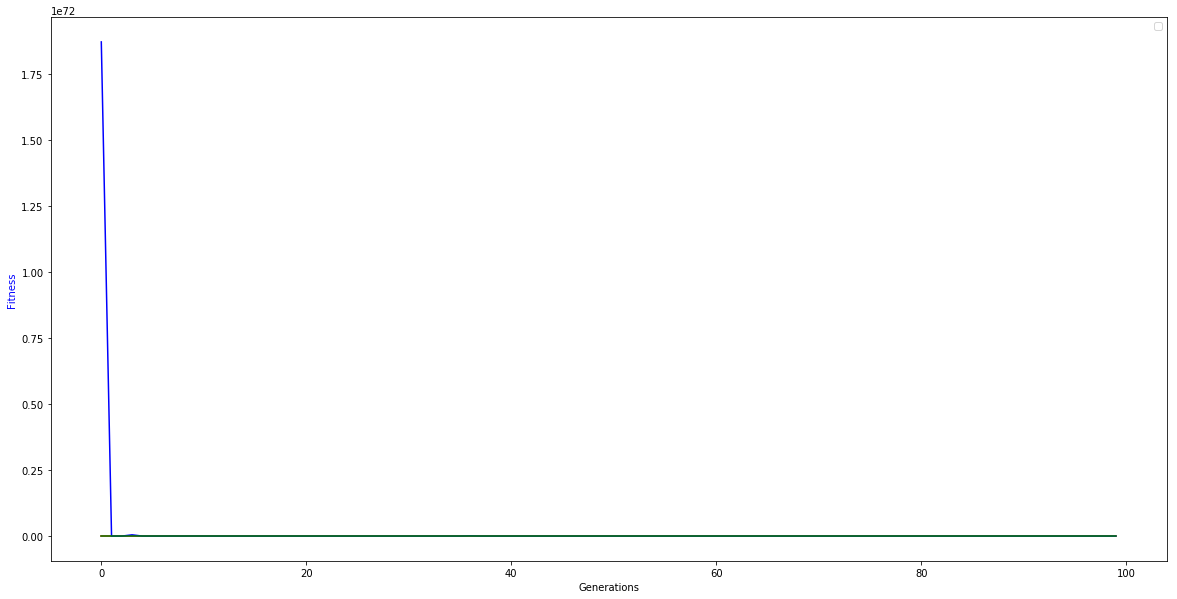

(1.773875062027875e+51,)


In [114]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
fig.set_figwidth(20)
fig.set_figheight(10)
line1 = ax1.plot(gen, Min, "r-")
ax1.legend()
line2 = ax1.plot(gen, avg, "b-")
line3 = ax1.plot(gen, g_history, "g-")
#ax1.set_yscale('log')

ax1.set_xlabel("Generations")
ax1.set_ylabel("Fitness", color="b")

plt.show()
print(g.fitness.values)

In [85]:
'''conclusion: Particle Swarm Optimization (PSO) is a global optimization algorithm
   and probabilistic in nature since it contains random processes
   The swarm concept was originally studied to graphically simulate the graceful
   and unpredictable choreography of a bird flock. However,
   we’ve implemented the PSO algorithm to solve a nonlinear control theory problem.
   The algorithm is able to find the control u with high precision.and during this case we find the the cognitive and the social abilities when they take the lowest value the best solution could be lower compared with previous tested algorithm '''


'conclusion: Particle Swarm Optimization (PSO) is a global optimization algorithm\n   and probabilistic in nature since it contains random processes\n   The swarm concept was originally studied to graphically simulate the graceful\n   and unpredictable choreography of a bird flock. However,\n   we’ve implemented the PSO algorithm to solve a nonlinear control theory problem.\n   The algorithm is able to find the control u with high precision.'